In [1]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
path= '/content/drive/MyDrive/dump'


100%|██████████| 322/322 [00:13<00:00, 24.03it/s]

number of images :  322
resolution of images :  (1024, 1024, 3)


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import pylab as pylab
from skimage import io
from skimage import color
import cv2

from skimage.feature import canny
from skimage.filters import sobel






In [3]:

def right_orient_mammogram(image):
    left_nonzero = cv2.countNonZero(image[:, 0:int(image.shape[1]/2)])
    right_nonzero = cv2.countNonZero(image[:, int(image.shape[1]/2):])
    if(left_nonzero < right_nonzero):
        image = cv2.flip(image, 1)
    return image    

In [10]:
def read_image(filename):
    image = cv2.imread(filename)
    image = color.rgb2gray(image)
    image = right_orient_mammogram(image)
    return image

In [24]:
def apply_canny(image):
    canny_img = canny(image, 5)
    #return sobel(canny_img)
    return canny_img

In [6]:
from skimage.transform import hough_line, hough_line_peaks
def get_hough_lines(canny_img):
    h, theta, d = hough_line(canny_img)
    lines = list()
    print('\nAll hough lines')
    for _, angle, dist in zip(*hough_line_peaks(h, theta, d)):
        print("Angle: {:.2f}, Dist: {:.2f}".format(np.degrees(angle), dist))
        x1 = 0
        y1 = (dist - x1 * np.cos(angle)) / np.sin(angle)
        x2 = canny_img.shape[1]
        y2 = (dist - x2 * np.cos(angle)) / np.sin(angle)
        lines.append({
            'dist': dist,
            'angle': np.degrees(angle),
            'point1': [x1, y1],
            'point2': [x2, y2]
        })
    return lines

In [7]:
def shortlist_lines(lines):
    MIN_ANGLE = 10
    MAX_ANGLE = 70
    MIN_DIST  = 5
    MAX_DIST  = 256
    shortlisted_lines = [x for x in lines if 
                          (x['dist']>=MIN_DIST) &
                          (x['dist']<=MAX_DIST) &
                          (x['angle']>=MIN_ANGLE) &
                          (x['angle']<=MAX_ANGLE)
                        ]
    print('\nShorlisted lines')
    for i in shortlisted_lines:
        print("Angle: {:.2f}, Dist: {:.2f}".format(i['angle'], i['dist']))
    return shortlisted_lines


All hough lines
Angle: 0.50, Dist: 192.57
Angle: -0.50, Dist: 180.56
Angle: -1.51, Dist: 643.72
Angle: 18.60, Dist: 343.62
Angle: -1.51, Dist: 742.76
[{'dist': 192.56644804970665, 'angle': 0.5027932960893821, 'point1': [0, 21944.179533573337], 'point2': [1024, -94742.68291092559]}, {'dist': 180.56230583362094, 'angle': -0.5027932960893948, 'point1': [0, -20576.23067953187], 'point2': [1024, 96110.6317649641]}, {'dist': 643.7221263375905, 'angle': -1.508379888268159, 'point1': [0, -24454.596621854307], 'point2': [1024, 14433.036220182557]}, {'dist': 343.6185709354504, 'angle': 18.60335195530725, 'point1': [0, 1077.1243798984726], 'point2': [1024, -1965.0413035873894]}, {'dist': 742.7562996202969, 'angle': -1.508379888268159, 'point1': [0, -28216.842255985746], 'point2': [1024, 10670.790586051116]}]

Shorlisted lines
[]


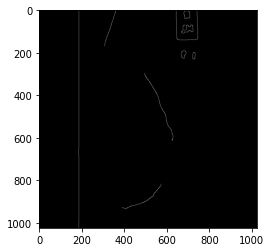

In [29]:
image = read_image('/content/drive/MyDrive/dump/mdb004.png')
#plt.imshow(image,cmap='gray')
canny_image = apply_canny(image)
plt.imshow(canny_image,cmap='gray')
lines = get_hough_lines(canny_image)
print(lines)
shortlisted_lines = shortlist_lines(lines)

print(shortlisted_lines)

In [15]:
from skimage.draw import polygon
def remove_pectoral(shortlisted_lines):
    shortlisted_lines.sort(key = lambda x: x['dist'])
    pectoral_line = shortlisted_lines[0]
    d = pectoral_line['dist']
    theta = np.radians(pectoral_line['angle'])
    x_intercept = d/np.cos(theta)
    y_intercept = d/np.sin(theta)
    return polygon([0, 0, y_intercept], [0, x_intercept, 0])

In [25]:

image = read_image('/content/drive/MyDrive/dump/mdb001.png')
canny_image = apply_canny(image)
lines = get_hough_lines(canny_image)
shortlisted_lines = shortlist_lines(lines)
rr, cc = remove_pectoral(shortlisted_lines)
image[rr, cc] = 0
plt.imshow(image)
    #cv2.imwrite('image13.png', image)


All hough lines
Angle: -0.50, Dist: 250.59

Shorlisted lines


IndexError: ignored